# TGA DAEN Preliminary Analysis

The [TGA DAEN](https://apps.tga.gov.au/Prod/devices/daen-report.aspx) is the Australian Therapeutic Goods Administration Database of Adverse Event Notifications. It is smaller in quanity of data but this is a usedful property at times.

The data is not easily accessed and must be scraped using selenium from the TGA website. An inital scraping has been done using the names of all listed sponsors as the search keys. Code to perform this can be seen in the `tgaScraping/` subfolder.

# Setup

This is simply the setup code I use in all python notebooks.

In [3]:
"""
Preamble for most code and jupyter notebooks
@author: tobinsouth
@notebook date: 11 Jul 2021
"""

import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl, seaborn as sns
import math, string, re, pickle, json, os, sys, datetime, itertools
from collections import Counter # This is useful for counting things
from tqdm import tqdm # This makes progress bars

# Set panda's options
pd.set_option("display.max_rows", 60)
pd.set_option("display.max_columns", 120)

# Better graphics
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use('seaborn-notebook')

## Data Load and Basic Analysis

The data is stored in two formats. For each sponsor that was searched for in the database, we saved the summaries table of medical devices to `medical_device_summaries/medical_device_summary_key_<sponsor name>.csv` and we saved the list of device reports to `list_of_reports/list_of_reports_<sponsor name>.pickle`. Pickle is a special binary format that is easy to read and write in python. To use these reports in other languages you will need to load them in an conert them to csv. The reason they are not in csv already is that the `Other medical devices reported as being used` field sometimes has a table within that element. Drop this column before converting to csv.


In future, I would recommend we rerun the scraping to collect more data and update it.

In [4]:
all_reports = []
for file in os.listdir("data/list_of_reports"):
    if file[-6:] == 'pickle':
        if file[:16] == 'list_of_reports_':
            with open('data/list_of_reports/'+file, 'rb') as f:
                all_reports.extend(pickle.load(f))
                
# # Remove other devices links
for r in all_reports:
    r.pop('other medical devices reported as being used', None)

all_reports_df = pd.DataFrame(all_reports)
all_reports_df['Report date'] = pd.to_datetime(all_reports_df['Report date'], errors='coerce')
print(f'Removing {len(all_reports_df.drop_duplicates())} duplicates out of {len(all_reports_df)}.')
all_reports_df = all_reports_df.drop_duplicates() # Removing duplicate entries 

Removing 21381 duplicates out of 92702.


In [5]:
all_reports_df.head(2) # Show first two rows

Report number Report date  \
0         27195  2012-02-07   
1         27422  2012-07-20   

                                          Trade name  \
0  ALTRUA 40 DDDR-EL Dual Chamber Extended Longev...   
1                                       Quartet Lead   

                                Sponsor  \
0  annes test Boston Scientific Pty Ltd   
1      Abbott Medical Australia Pty Ltd   

                                        Manufacturer ARTG number  \
0                             Cardiac Pacemakers Inc      158085   
1  St Jude Medical Cardiac Rhythm Management Divi...      171332   

                                   GMDN term  \
0            Pacemaker, cardiac, implantable   
1  Lead, pacemaker, implantable, endocardial   

               Device classification Sterile Single use Model number  \
0  Active Implantable Medical Device     Yes        Yes         S404   
1                          Class III     Yes        Yes     1458Q/75   

  Software version Reported event outcome Report source category  \
0                -                 Injury               Industry   
1                -                 Injury               Industry   

              Event type                                  Event description  \
0  Electrical/Electronic  It was reported that the patient with this dev...   
1             Mechanical  The Doctor attempted to suture the Atrial lead...   

       Other medical devices reported as being used  
0  NaN                                          NaN  
1  NaN                                          NaN

In [6]:
# This is what an event description looks like in a report:
all_reports_df['Event description'].iloc[0] 

"It was reported that the patient with this device experienced a fall and was hospitalized. It could not be determined if the patient lost conciousness. There was concern that this may have been due to a device issue. Interrogation revealed increased right ventricular threshold measurements and lack of pacing at the programmed output settings. In addition, there was loss of ventricular capture in unipolar settings, however when reprogrammed to bipolar setting, normal impedance, sensing and threshold measurements were obtained. The patient was scheduled for a cath laboratory procedure. When the pocket was opened, visual observation suggested that the right ventricular lead tip had moved and may have perforated the right ventricle. It was thought this may have contributed to the observation, however a device issue could not be ruled out. Due to the patient's age and medical condition,a decision was made to leave the system intact and the pocket was closed.\nApproximately, one month later

Some quick summary statistics on the DAEN data.

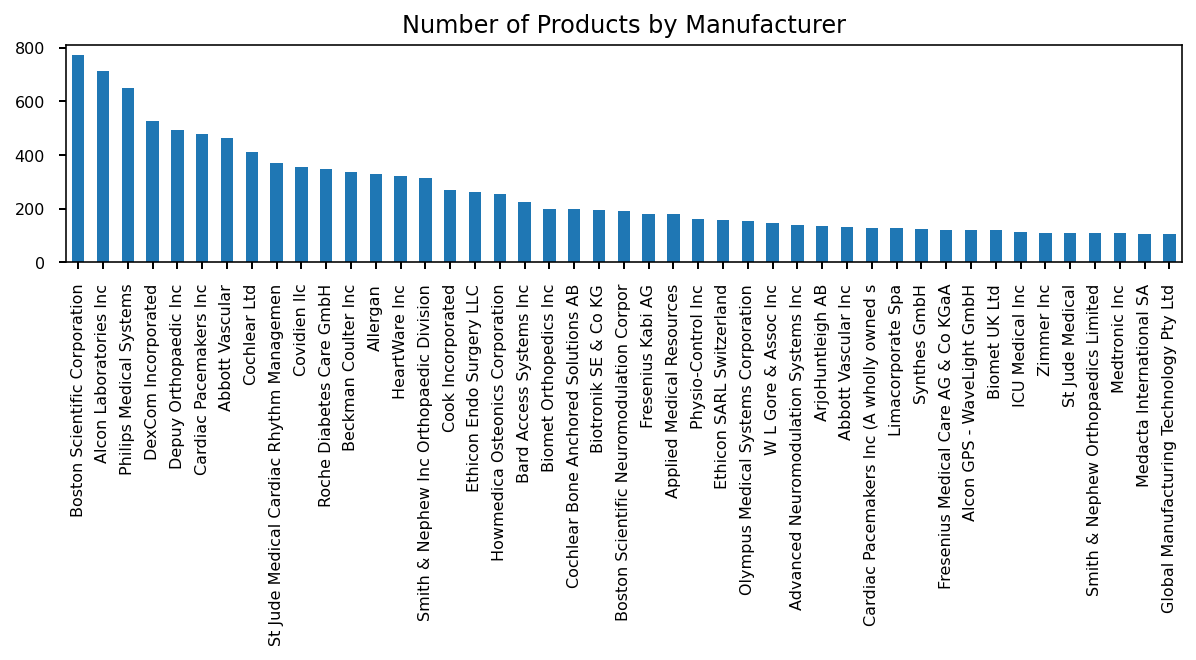

In [7]:
Manufacturers = all_reports_df['Manufacturer'].value_counts() 
Manufacturers.index = [x[:40] for x in Manufacturers.index]
with mpl.rc_context({'xtick.labelsize': 8,'ytick.labelsize': 8}):
    Manufacturers[Manufacturers>=100].plot.bar(figsize=(10,2), title='Number of Products by Manufacturer');

You will notice that some manufacturer appear mutiple times in the list. We will need to map these together later.

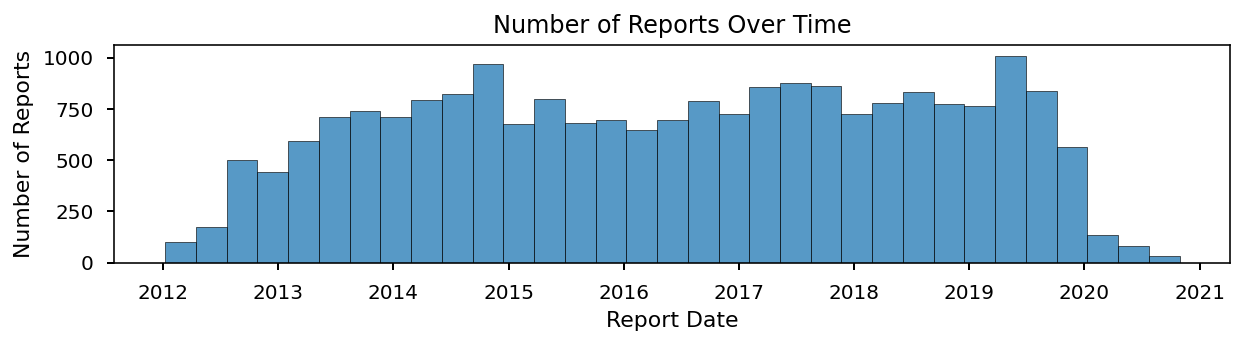

In [8]:
plt.subplots(figsize=(10,2))
ax = sns.histplot(all_reports_df['Report date'].dropna().values.astype('datetime64[D]'))
ax.set(xlabel='Report Date', ylabel='Number of Reports', title = 'Number of Reports Over Time');

Visualisation the word cloud of GMDN terms.

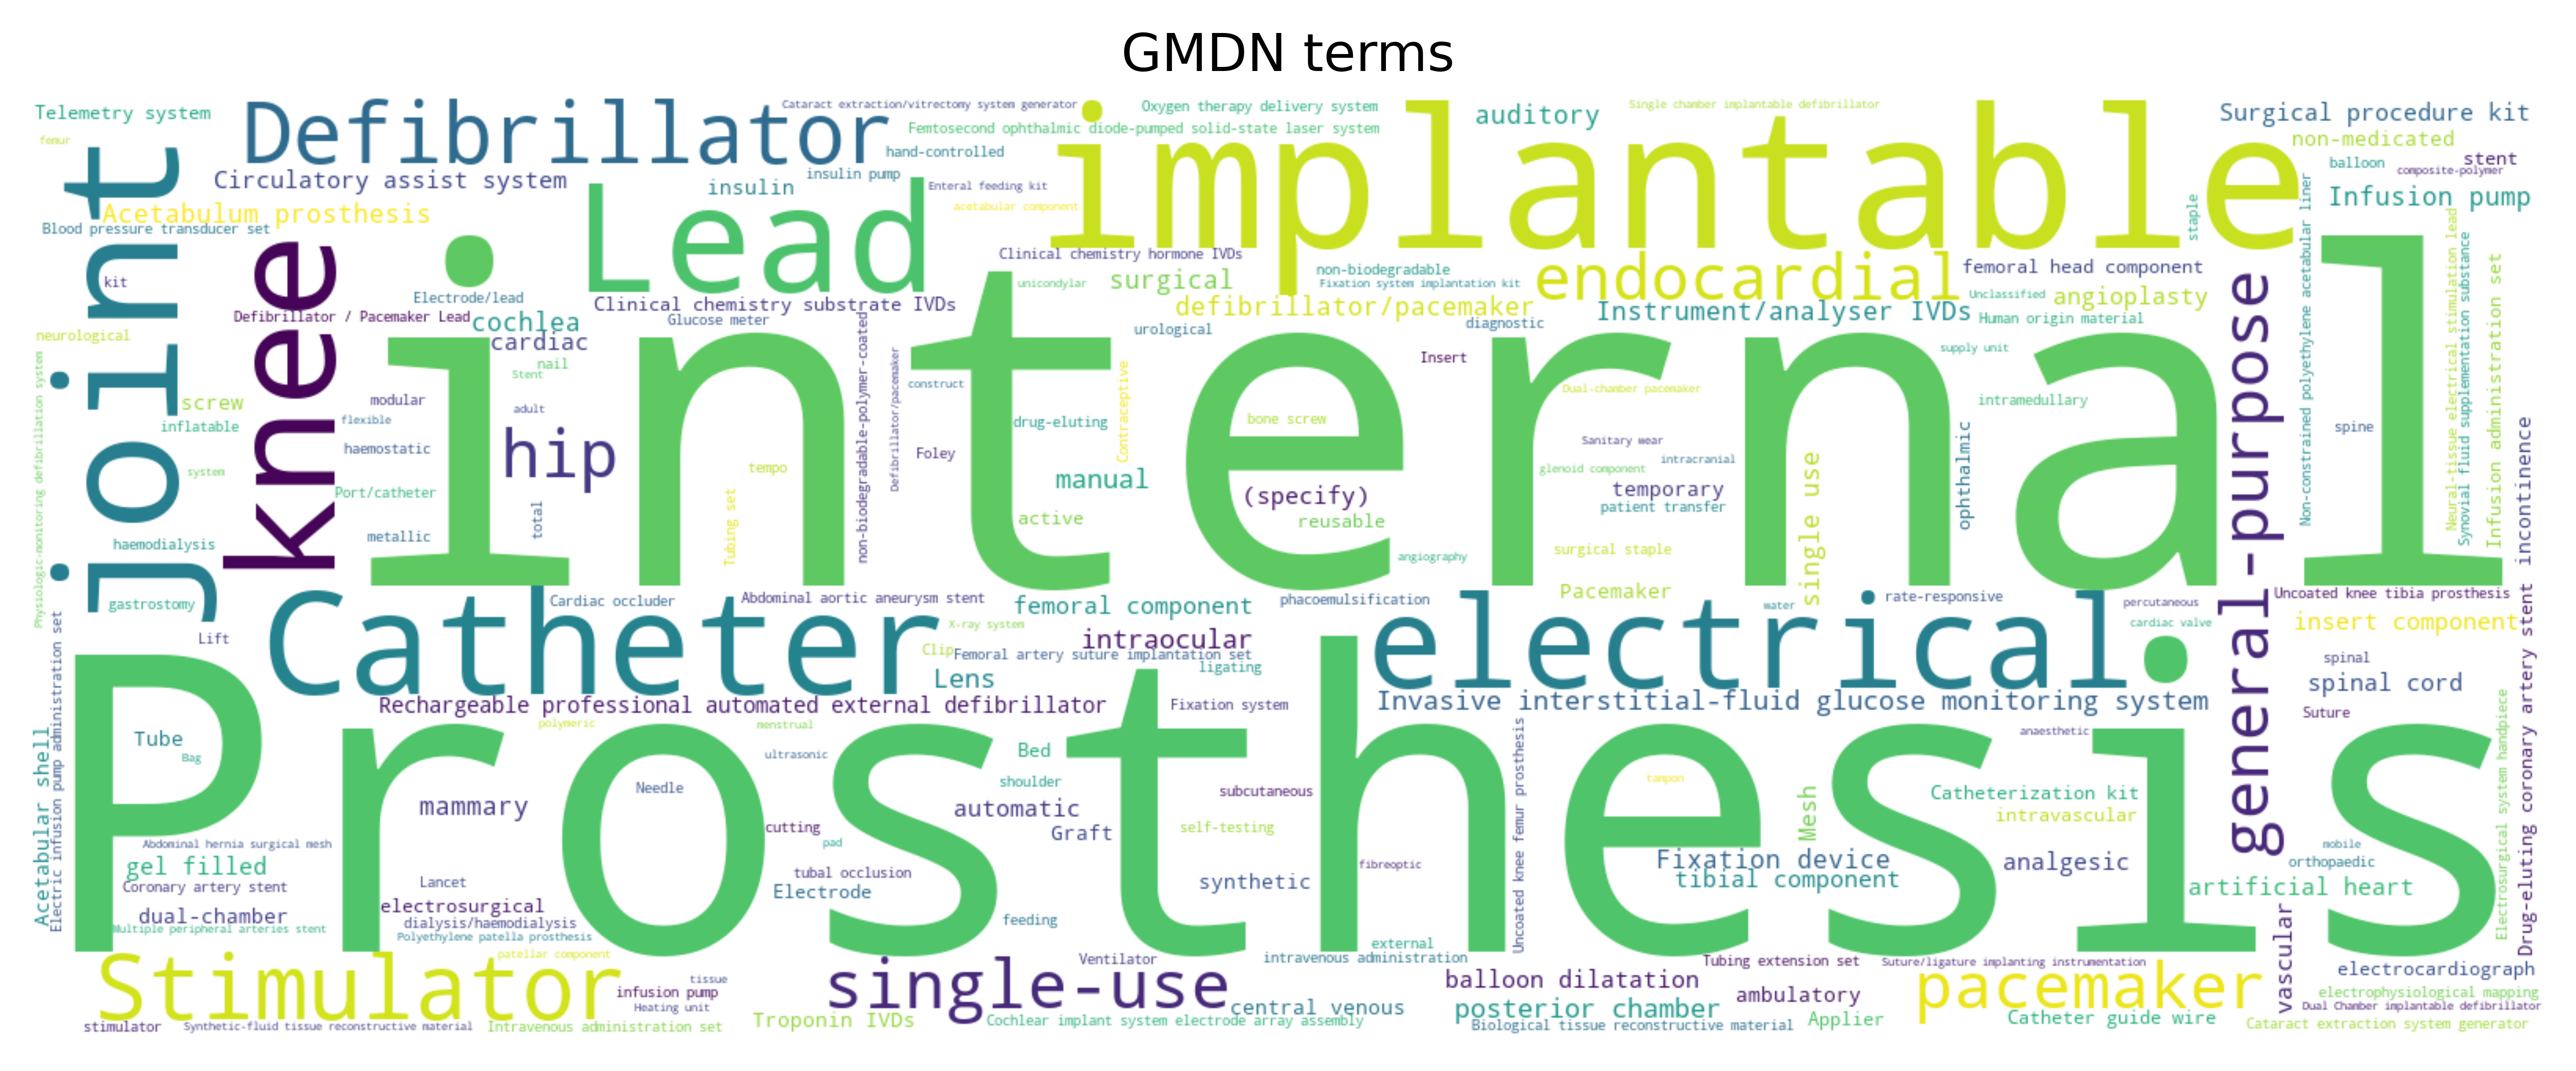

In [18]:
# This is an example word cloud
from wordcloud import WordCloud

all_grams_counts = Counter(list(itertools.chain.from_iterable(all_reports_df['GMDN term'].str.split(', '))))
stopwords = WordCloud().stopwords
wordcloud = WordCloud(width=1600, height=600, background_color='white').fit_words({w:c for w,c in all_grams_counts.items() if w not in stopwords})

plt.figure(facecolor = None, dpi=500)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('GMDN terms')
plt.tight_layout(pad=0)
plt.show()

# Resources

These are a set of tools that we will use throughout this notebook for analysis.

### Tokenizer
Tokenizing is the process of splitting strings into word units. There are better ways to do this by far, but the regex tokenizer is simple and very fast. In future consider a custom approach that removed common formatting.

In [9]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(pattern = '\w+') # Get only words
tokenize = tokenizer.tokenize # Map the function call to a clean variable

### Baseline word frequencies

These will be used to calculate the suprise of a word. We get the word frequence access the whole corpus of even descriptions.

`itertools.chain.from_iterable` is a useful function that takes a list of lists and joins it together to make a single list.

`Counter` is a function that counts the number of times a word appears in a list and returns a dictionary-like object.

In [10]:
all_tokenized_event_descriptions = all_reports_df['Event description'].str.lower().apply(tokenize) # Apply tokenizer
all_tokenized_words = list(itertools.chain.from_iterable(all_tokenized_event_descriptions)) # Expand to single list
overall_word_freq = Counter(all_tokenized_words) # Count elements in list

### Association Measures

This is a tool from NLTK which calculates the p-value of a two words coocurring in a corpus. E.g. when you see two words appear more offen than a baseline frequence then they are a common pair. This is normal used for bigrams but we're using it more generally. Check the docs.

https://www.nltk.org/_modules/nltk/metrics/association.html

https://www.nltk.org/howto/collocations.html

In future we should work on using our own method to do this and back it up with the litterature.

In [23]:
import nltk
bigram_measures = nltk.collocations.BigramAssocMeasures() # Use for computing scores

def collocation_scores(all_singles_list, all_pairs_list):
    """
    Calculates the t-statistic a pair in all_pairs_list being signifcantly more frequent than predicted by the base frequencies in all_singles_list.

    Args:
        all_singles_list (list): A list of all tokens in corpus.
        all_pairs_list (list): A list of all pairs of interest (ungrouped).
    """

    single_frequencies = nltk.FreqDist(all_singles_list)
    pair_frequencies = nltk.FreqDist(all_pairs_list)
    finder = nltk.collocations.BigramCollocationFinder(single_frequencies, pair_frequencies)
    scores = finder.score_ngrams(bigram_measures.student_t) # likelihood_ratio
    return scores

### Merging manufacturers to avoid future errors

This is a really annoying problem in the data and this is only an example solution.

In [11]:
simple_term_list = ['American Medical Systems', 'Boston Scientific', 'Ethicon', 'Atrium', 'Coloplast', 'Sofradim', 'Gore & Assoc', 'St Jude', 'Johnson & Johnson']
def collapse_to_simplest_manufacturer_term(full_term):
    for simple_term in simple_term_list:
        if simple_term in full_term:
            return simple_term
    return full_term

all_reports_df['Manufacturer'] = all_reports_df['Manufacturer'].map(collapse_to_simplest_manufacturer_term)

# Example case studies on vaginal mesh

Here we will examine the methods so far developed in the context of vaginal mesh devices. To get these devices we simply select the device reports that have mesh in their GMDN terms. There are also other ways to filter.

In [37]:
mesh_reports = all_reports_df[all_reports_df['GMDN term'].apply(lambda s: 'Mesh,' in s)]
print('Outcome counts', mesh_reports['Reported event outcome'].value_counts().to_dict())
mesh_reports = mesh_reports[mesh_reports['Reported event outcome'] == 'Injury'] # Select only injuries
mesh_reports = mesh_reports.set_index('Report number') # Set index
event_descriptions = mesh_reports['Event description'].str.lower().apply(tokenize).to_dict()
print('Number of reports =', len(mesh_reports))

Outcome counts {'Injury': 258, 'No Injury': 7, 'Not Known': 2}
Number of reports = 258


We will now enumerate through some key methods we have discussed for finding interesting signals in the data.

## 1. Finding indicative words

This is the class of problems where we only look for single words at a time. In general this involves looking at the frequency of each word in the text and comparing it to a baseline.

### 1.1 Compared to total corpus

Here we compare the frequency of a word in the mesh device category to the overall corpus of text (all reports). We see that this mostly highlighs words that are relevent to the device category such as prolapse, vaginal or mesh.

In [9]:
mesh_corpus_wc = Counter(list(itertools.chain.from_iterable(event_descriptions.values())))
mesh_corpus_wc_df = pd.DataFrame([(word, wc, overall_word_freq[word], wc/overall_word_freq[word]) for word, wc in mesh_corpus_wc.items()], columns=['Word', 'Count', 'Total', 'Ratio']).sort_values(by='Ratio', ascending=False).reset_index(drop=True)
mesh_corpus_wc_df.query('Count > 15').head(10).reset_index(drop=True)

Word  Count  Total     Ratio
0     prolapse     53     85  0.623529
1  compartment     24     41  0.585366
2      vaginal    107    194  0.551546
3         mesh    243    443  0.548533
4          sex     19     35  0.542857
5   recurrence     21     51  0.411765
6      erosion     56    142  0.394366
7      urethra     16     41  0.390244
8       hernia     41    106  0.386792
9       pelvic     55    146  0.376712

### 1.2 Compare word frequency between manufacturers

A more interesting question is to compare the frequency of words between device manufacturers. To do this properly we need to normalise the contribution by the total proportion of reports by the manufacturer. This generally yields poor results due to the small number of reports in a given category.

In [77]:
mesh_corpus_wc = Counter(list(itertools.chain.from_iterable(event_descriptions.values()))) # Get all words in the 
word_counts = []
for manufacturer, man_df in mesh_reports.groupby('Manufacturer'):
    if len(man_df) > 10:
        man_corpus_wc = Counter(list(itertools.chain.from_iterable([event_descriptions[i] for i in man_df.index]))) # Get this manufacturers words
        total_man_wc = sum(man_corpus_wc.values()) # Count up all words
        for word, wc in man_corpus_wc.items():
            word_counts.append((manufacturer, word, wc, mesh_corpus_wc[word], total_man_wc))

word_counts_df = pd.DataFrame(word_counts, columns = ['Manufacturer', 'Word', 'Count', 'Corpus', 'ManufacturerTotal'])

In [80]:
# We now normalise a word by its frequency in the mesh category and by the manufacturer dominance.
word_counts_df['CorpusTotal'] = sum(mesh_corpus_wc.values())
word_counts_df['freqRatio'] = (word_counts_df['Count'] / word_counts_df['Corpus']) / (word_counts_df['ManufacturerTotal'] / word_counts_df['CorpusTotal'])

word_counts_df.query('Count > 20').sort_values('freqRatio', ascending=False).head(10)

Manufacturer          Word  Count  Corpus  \
2128                   Ethicon   compartment     24      24   
829          Boston Scientific     procedure     24      50   
821          Boston Scientific            an     24      50   
827          Boston Scientific        during     22      47   
2323         Johnson & Johnson       patient     25     154   
1792                   Ethicon      prolapse     31      53   
85    American Medical Systems  incontinence     36      45   
814          Boston Scientific            it     23      70   
223   American Medical Systems       chronic     21      30   
348   American Medical Systems         groin     21      31   

      ManufacturerTotal  CorpusTotal  freqRatio  
2128               2288         9375   4.097465  
829                1436         9375   3.133705  
821                1436         9375   3.133705  
827                1436         9375   3.055918  
2323                586         9375   2.597126  
1792               2288         9375   2.396630  
85                 3155         9375   2.377179  
814                1436         9375   2.145096  
223                3155         9375   2.080032  
348                3155         9375   2.012934

In [81]:
# TODO: TFIDF (an alterntive way to do this using documents as manufacturers)

## 2. Non-vocabulary extracting common pairs

We now turn our attention to the task of finding interesting pairs of words for a device category / manufacturer. 

There are two main challenges here:

1. We need to find a vocubulary of words to investigate.
2. We need to find pairs that are significant.

We first look at avoiding (1) all together in favour of pure discovery.

In [90]:
all_singles = list(all_tokenized_words) # All single freq words
all_pairs = list(itertools.chain.from_iterable([[p for p in itertools.permutations(d, r=2) if p[0]!=p[1]] for d in event_descriptions.values()])) # All pairs in mesh
all_pairs_global = list(itertools.chain.from_iterable([[p for p in itertools.permutations(d, r=2) if p[0]!=p[1]] for d in tqdm(all_tokenized_event_descriptions)])) # All pairs in corpus

100%|██████████| 21381/21381 [00:04<00:00, 4684.35it/s]


`collocation_scores` looks at the frequency of a pair given the single token frequencies. Without a vocabulary this will just find signifcant word pairs like 'and' and 'the'.

In [85]:
# collocation_scores(all_singles,all_pairs) # This doesn't work well 

As an alternative we can compare the frequency between the total corpus and the device category.

In [91]:
all_pairs_global_counts = Counter(all_pairs_global)
all_pairs_counts = Counter(all_pairs)

In [92]:
pair_counts = pd.DataFrame([(sorted(p)[0],sorted(p)[1], count, all_pairs_global_counts[p], count/all_pairs_global_counts[p]) for p, count in all_pairs_counts.most_common()], 
columns = ['word1', 'word2', 'count', 'global_pairs_count', 'ratio']).drop_duplicates().sort_values(by = 'ratio', ascending = False)
pair_counts.query('ratio > 0.95').sort_values('count', ascending = False).head(10)

word1        word2  count  global_pairs_count     ratio
22   compartment           in    746                 757  0.985469
44            in     prolapse    577                 603  0.956882
98   compartment     prolapse    348                 348  1.000000
134  compartment          had    299                 313  0.955272
142     anterior  compartment    279                 284  0.982394
144  compartment     patients    279                 279  1.000000
203       apical           in    224                 227  0.986784
208  compartment         mesh    221                 224  0.986607
220     anterior     prolapse    207                 214  0.967290
228          had     prolapse    200                 209  0.956938

## 3. Vocabulary based relationships

### 3.1 Manual vocabulary

Here we manually pick the vocabulary for a set of medical problems and for a set of actvities. We then find a set of relationships.

In [96]:
from nltk.corpus import stopwords # This section relies on removing stopwords from the text
stopwords = stopwords.words('english')

In [97]:
# Manually define problems and activites
problems = ['dehiscence', 'discoloration', 'hernia', 'pain', 'incontinence', 'prolapse', 'pelvic prolapse', 'complications', 'infection', 'infections', 'painful', 'seroma', 'cystocele', 'dyspareunia', 'inflammation', 'discomfort', 'stress', 'complications', 'inflammation', 'recurrence'] + \
['mesh erosion', 'pain severe', 'severe scarring', 'scarring', 'bladder syndrome', 'overactive bladder', 'incisional hernia', 'hernia recurrence', 'constant pain', 'abdominal pain', 'pain intercourse', 'nerve pain', 'stress incontinence', 'umbilical hernia', 'tract infections', 'leg pain', 'painful sex', 'urinary incontinence', 'incontinence pain', 'cystocele recurrence', 'ongoing pain', 'ability walk', 'extreme pain', 'unable sex'] 
activites = ['intercourse',  'overactive'] + ['experienced post', 'removed meshes', 'sexual intercourse']

In [98]:
report_word_map = {}
for i, report_text in event_descriptions.items(): # Loop through event descriptions
    report_text = [t for t in report_text if t not in stopwords] # Remove stopwords from tokens
    found_activities = [a for a in activites if a in " ".join(report_text)] # Join and search for ocurrences of activities
    found_probelms = [p for p in problems if p in " ".join(report_text)]
    report_word_map[i] = {'act':found_activities, 'medprob':found_probelms} # Save result of search

In [104]:
all_singles = list(itertools.chain.from_iterable([r['act']+r['medprob'] for r in report_word_map.values()]))
all_pairs = list(itertools.chain.from_iterable([ [(act, prob) for act in r['act'] for prob in r['medprob']] for r in report_word_map.values()]))
pairs = pd.DataFrame([(p1,p2,score) for (p1,p2), score in collocation_scores(all_singles,all_pairs)], columns = ['problem','activity','score'])
pairs_wide = pairs.pivot(index='problem', columns='activity',values='score').fillna(0) # Make a matrix

[Text(0.5, 135.9290909090909, 'Association\nt-statistic')]

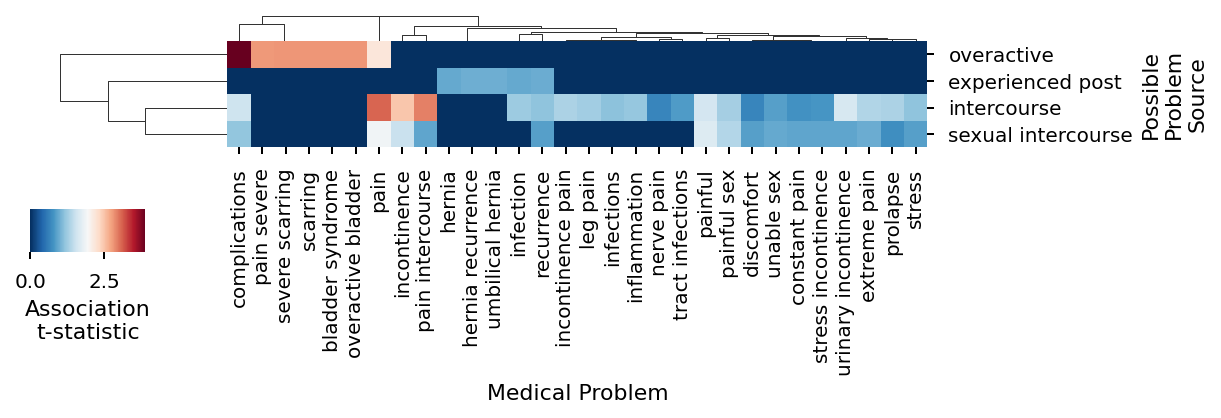

In [105]:
clustermap = sns.clustermap(data = pairs_wide, figsize = (8,3), cmap='RdBu_r', cbar_pos=(0,0.4, 0.1,0.1), cbar_kws={"orientation": "horizontal"})
clustermap.ax_heatmap.set(xlabel = 'Medical Problem', ylabel='Possible\nProblem\nSource')
clustermap.ax_cbar.set(xlabel = 'Association\nt-statistic')

### 3.2 Large corpus vocabulary

An alternative approach is to use a large generalist corpus of words. Here we use a corpus of adverse events as classified by [IMDRF](http://imdrf.org/documents/documents.asp) and a corpus of physical activities from [ 2011 Adult Compendium of Physical Activities](https://sites.google.com/site/compendiumofphysicalactivities/home). In both cases we fiddle with the word lists to make them more suitable.

In [106]:
# Get t vocab list of medical problem terms 
# Attached also a list with terminology of possible adverse events as classified by [IMDRF](http://imdrf.org/documents/documents.asp)
def expand_text_style(text):
    tokens = text.split('/')
    tokens = [t.replace('(s)','') for t in tokens]
    tokens = [t.split(',')[0].rstrip().lstrip() for t in tokens]
    return tokens + list(itertools.chain.from_iterable([t.split(' ') for t in tokens]))

medical_problems = []
for file in os.listdir('vocabulary'):
    if (file[:5] == 'annex') and (file[-5:] == '.json'):
        with open('vocabulary/'+file, "r") as f:
            annex = json.load(f)
            medical_problems.extend(annex)
medical_problem_terms = [p['term'].lower() for p in medical_problems]
medical_problem_terms = list(set(medical_problem_terms))
medical_problem_terms = list(itertools.chain.from_iterable([expand_text_style(text) for text in medical_problem_terms]))
medical_problem_terms = medical_problem_terms+list(itertools.chain.from_iterable([a.split() for a in medical_problem_terms]))
medical_problem_terms = [t for t in medical_problem_terms if (len(t) > 3) and (t not in stopwords)]
medical_problem_terms = list(set(medical_problem_terms)) # Remove duplicates


In [108]:
# Get a list of physical activities from [ 2011 Adult Compendium of Physical Activities](https://sites.google.com/site/compendiumofphysicalactivities/home)
CPA_activities = pd.read_csv('vocabulary/CPA_activities.csv')
all_activities = list(itertools.chain.from_iterable(CPA_activities['SPECIFIC ACTIVITIES'].str.split(',')))
all_activities.extend(CPA_activities['MAJOR HEADING'].to_list())
all_activities = list(set([a.rstrip().lstrip().lower() for a in all_activities if type(a) is str]))
all_activities = list(set(itertools.chain.from_iterable([expand_text_style(text) for text in all_activities])))
all_activities = all_activities+list(itertools.chain.from_iterable([a.split() for a in all_activities]))
all_activities = [a for a in all_activities if (len(a) > 3) and (a not in stopwords)]
all_activities = list(set(all_activities)) # Remove duplicates


In [109]:
# Find medical problem terms 
report_word_map_mesh = {}
for i, report_text in event_descriptions.items():
    found_activities = [a for a in all_activities if a in report_text]
    found_probelms = [p for p in medical_problem_terms if p in report_text]
    if len(found_activities)>0 and len(found_probelms)>0:
        report_word_map_mesh[i] = {'act':found_activities, 'medprob':found_probelms}

all_pairs_mesh= list(itertools.chain.from_iterable([ [(act, prob) for act in r['act'] for prob in r['medprob'] if act != prob] for r in report_word_map_mesh.values()]))


report_word_map_corpus = {}
for i, report_text in enumerate(tqdm(all_reports_df['Event description'].str.lower().apply(tokenize))):
    found_activities = [a for a in all_activities if a in report_text]
    found_probelms = [p for p in medical_problem_terms if p in report_text]
    if len(found_activities)>0 and len(found_probelms)>0:
        report_word_map_corpus[i] = {'act':found_activities, 'medprob':found_probelms}

all_pairs_corpus= list(itertools.chain.from_iterable([ [(act, prob) for act in r['act'] for prob in r['medprob'] if act != prob] for r in report_word_map_corpus.values()]))
corpus_counter = Counter(all_pairs_corpus)

100%|██████████| 21381/21381 [00:30<00:00, 705.22it/s]


In [110]:
# Compare pair frequecny in overal corpus to freq in reports of interest.
pair_ratios = pd.DataFrame([(pair[0],pair[1], count, corpus_counter[pair], count/corpus_counter[pair]) for pair, count in Counter(all_pairs_mesh).most_common()], columns = ['activity','problem', 'count', 'corpus_count', 'ratio']).sort_values('ratio', ascending = False)

significant_pairs = pair_ratios.query('count > 7') # Arbitrary cut off 

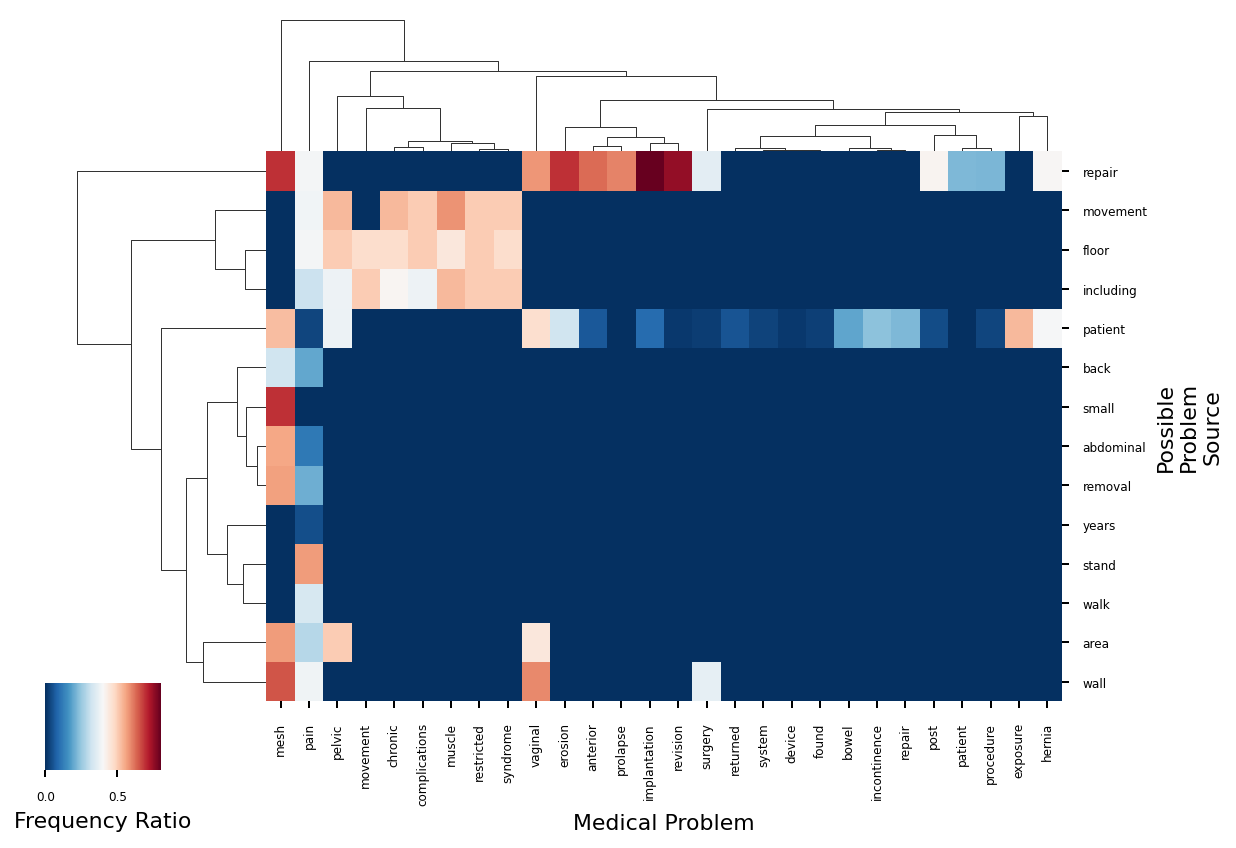

In [111]:
pairs_wide = significant_pairs.pivot(columns='problem', index='activity',values='ratio').fillna(0) 
with plt.rc_context({'xtick.labelsize': 6,'ytick.labelsize': 6}):
    clustermap = sns.clustermap(data = pairs_wide, figsize = (8,6), cmap='RdBu_r', cbar_pos=(0,0.1, 0.1,0.1), cbar_kws={"orientation": "horizontal"})
    clustermap.ax_heatmap.set(xlabel = 'Medical Problem', ylabel='Possible\nProblem\nSource')
    clustermap.ax_cbar.set(xlabel = 'Frequency Ratio')

## Bonus: spaCy

spaCy is a efficent nlp pipeline that tokenizes, creates text embeddings, does named entity recognition, part-of-speech tagging, dependency parsing, sentence segmentation, text classification, lemmatization, morphological analysis, entity linking and more. It great once you get it installed 🤞.

In [32]:
import spacy
nlp = spacy.load("en_core_web_sm") # GloVe based (will prompt you to download model')
# nlp = spacy.load("en_core_web_trf") # Transformer based but much slower

# You simply pass each bit of text to nlp and it will tokenize, analyse and return a document object
docs = [nlp(doc) for doc in tqdm(all_reports_df['Event description'])]

There is also a pretrained medical NLP model designed for spacy. But I can never get it to work.

In [2]:
# pip install git+https://github.com/NLPatVCU/medaCy.git
# pip install git+https://github.com/NLPatVCU/medaCy_model_clinical_notes.git
# from https://github.com/NLPatVCU/medaCy

# Currently this is broken for spacy 3.x.x
import medacy_model_clinical_notes
model = medacy_model_clinical_notes.load()
model.predict("The patient was prescribed 1 capsule of Advil for 5 days.")

## Bonus: sBERT

sBERT or sentence-BERT is a deep learning language model that can be used to create text embeddings.

In [31]:
# pip install -U sentence-transformers

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

#Our sentences we like to encode
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.',
    'The quick brown fox jumps over the lazy dog.']

#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)
# embeddings = model.encode(mesh_reports['Event descriptions'])

## Extra Bonus: 🤗

If you're really keen on this you should use [huggingface](https://huggingface.co/) to download a pretrain medical model. E.g. [this search](https://huggingface.co/models?search=medical) will return a list of pretrained medical models.